In [12]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import rotate
import random

### Result Directory

In [2]:
results_directory = 'results'
os.makedirs(results_directory, exist_ok=True)

### Module 1: Feature Detection

#### Task 1.1: Implement the Harris corner detector for a gray value image. You should compute the "cornerness" response function of each point based on the second moment matrix. The final feature selection will then pick the 1000 strongest points as the features of the image. Execute this detector on greyscale versions of the two images in the TwoViewAlignment data subdirectory. Include the results in your report.  

In [3]:
def harris_corner_detector(image, k=0.04, threshold=0.01):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    IxIx = Ix * Ix
    IyIy = Iy * Iy
    IxIy = Ix * Iy

    kernel_size = 5
    IxIx = cv2.GaussianBlur(IxIx, (kernel_size, kernel_size), 0)
    IyIy = cv2.GaussianBlur(IyIy, (kernel_size, kernel_size), 0)
    IxIy = cv2.GaussianBlur(IxIy, (kernel_size, kernel_size), 0)

    det_M = IxIx * IyIy - IxIy * IxIy
    trace_M = IxIx + IyIy

    harris_response = det_M - k * (trace_M**2)

    harris_response[harris_response < threshold * harris_response.max()] = 0

    corners = cv2.cornerHarris(harris_response.astype(np.float32), 2, 3, 0.04)

    indices = np.argpartition(corners.flatten(), -1000)[-1000:]
    corners = np.column_stack(np.unravel_index(indices, corners.shape))

    return corners

In [4]:
# Load images
image_left = cv2.imread("./data/image_sample_1.jpeg")
image_right = cv2.imread("./data/image_sample_2.jpeg")

# Apply Harris corner detector
corners_left = harris_corner_detector(image_left)
corners_right = harris_corner_detector(image_right)

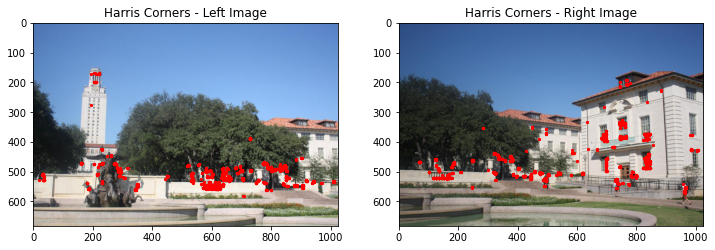

In [5]:
# Save the images in the 'results' directory
cv2.imwrite(os.path.join(results_directory, 'result_module_1_task_1.1_image_1.jpg'), image_left)
cv2.imwrite(os.path.join(results_directory, 'result_module_1_task_1.1_image_2.jpg'), image_right)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))
plt.scatter(corners_left[:, 1], corners_left[:, 0], c='r', s=5)
plt.title('Harris Corners - Left Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
plt.scatter(corners_right[:, 1], corners_right[:, 0], c='r', s=5)
plt.title('Harris Corners - Right Image')



plt.show()

#### Task 1.2: As you can observe in step one typically the selected features cluster. To avoid this behavior implement a non-maxima suppression. Include the results in your report.

In [6]:
def harris_non_maxima_suppression(image, k=0.04, window_size=3, threshold=0.01, max_corners=1000):

    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    IxIx = Ix * Ix
    IyIy = Iy * Iy
    IxIy = Ix * Iy

    Sxx = cv2.GaussianBlur(IxIx, (window_size, window_size), 0)
    Syy = cv2.GaussianBlur(IyIy, (window_size, window_size), 0)
    Sxy = cv2.GaussianBlur(IxIy, (window_size, window_size), 0)

    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    R_max = np.max(R)
    R[R < threshold * R_max] = 0
    corners = np.argwhere(R != 0)
    sorted_corners = corners[np.argsort(R[corners[:, 0], corners[:, 1]])[::-1]]
    selected_corners = sorted_corners[:max_corners]

    return selected_corners

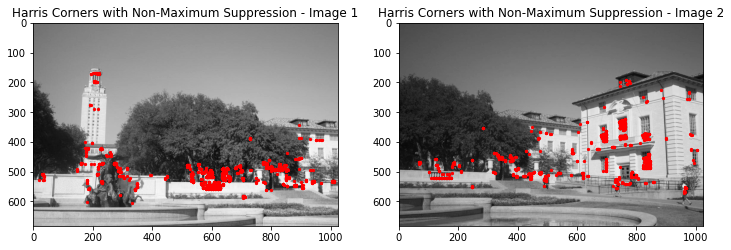

In [7]:
image_path_1 = "./data/image_sample_1.jpeg"
image_path_2 = "./data/image_sample_2.jpeg"

image_1 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE)
image_2 = cv2.imread(image_path_2, cv2.IMREAD_GRAYSCALE)

cv2.imwrite(os.path.join(results_directory, 'result_module_1_task_1.2_image_1.jpg'), image_1)
cv2.imwrite(os.path.join(results_directory, 'result_module_1_task_1.2_image_2.jpg'), image_2)


corners_1 = harris_non_maxima_suppression(image_1)
corners_2 = harris_non_maxima_suppression(image_2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_1, cmap='gray')
axes[0].scatter(corners_1[:, 1], corners_1[:, 0], c='r', s=5)
axes[0].set_title('Harris Corners with Non-Maximum Suppression - Image 1')

axes[1].imshow(image_2, cmap='gray')
axes[1].scatter(corners_2[:, 1], corners_2[:, 0], c='r', s=5)
axes[1].set_title('Harris Corners with Non-Maximum Suppression - Image 2')

plt.show()

#### Task 1.3: Compute a patch similarity measure (e.g. SSD, NCC) of your choice for every feature in the left image to every feature in the right image. Plot the correspondences of the best N=20 matching features (e.g. put both images side by side with lines connecting the correspondences). Include the results in your report. Discuss difference between using SSD and NCC.

In [8]:
def compute_patch_similarity(image1, image2, keypoints1, keypoints2, patch_size=15, similarity_measure='ssd'):
    matches = []
    
    for keypoint1 in keypoints1:
        patch1 = image1[
            keypoint1[0] - patch_size // 2:keypoint1[0] + patch_size // 2 + 1,
            keypoint1[1] - patch_size // 2:keypoint1[1] + patch_size // 2 + 1
        ]

        # Calculate similarity scores
        scores = []

        for keypoint2 in keypoints2:
            patch2 = image2[
                keypoint2[0] - patch_size // 2:keypoint2[0] + patch_size // 2 + 1,
                keypoint2[1] - patch_size // 2:keypoint2[1] + patch_size // 2 + 1
            ]

            if similarity_measure == 'ssd':
                score = np.sum((patch1 - patch2) ** 2)
            elif similarity_measure == 'ncc':
                score = -np.sum((patch1 - np.mean(patch1)) * (patch2 - np.mean(patch2))) / (
                        np.std(patch1) * np.std(patch2) * patch_size * patch_size
                )
            else:
                raise ValueError("Invalid similarity_measure. Use 'ssd' or 'ncc'.")

            scores.append(score)

        best_match_index = np.argmin(scores)
        best_match_keypoint = keypoints2[best_match_index]
        matches.append((keypoint1, best_match_keypoint))

    return matches

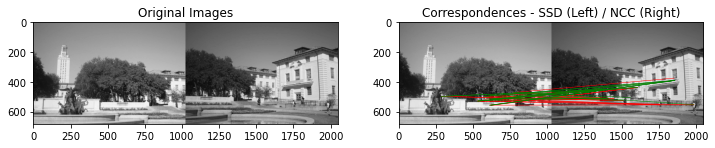

In [9]:
image_left = cv2.imread("./data/image_sample_1.jpeg", cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread("./data/image_sample_2.jpeg", cv2.IMREAD_GRAYSCALE)

corners_left = harris_non_maxima_suppression(image_left)
corners_right = harris_non_maxima_suppression(image_right)

N = 20

matches_ssd = compute_patch_similarity(image_left, image_right, corners_left[:N], corners_right[:N], similarity_measure='ssd')

matches_ncc = compute_patch_similarity(image_left, image_right, corners_left[:N], corners_right[:N], similarity_measure='ncc')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(np.hstack((image_left, image_right)), cmap='gray')
axes[0].set_title('Original Images')

axes[1].imshow(np.hstack((image_left, image_right)), cmap='gray')
axes[1].set_title('Correspondences - SSD (Left) / NCC (Right)')

for match in matches_ssd:
    line_x = [match[0][1], match[1][1] + image_left.shape[1]]
    line_y = [match[0][0], match[1][0]]
    axes[1].plot(line_x, line_y, 'r-', linewidth=0.5)

for match in matches_ncc:
    line_x = [match[0][1], match[1][1] + image_left.shape[1]]
    line_y = [match[0][0], match[1][0]]
    axes[1].plot(line_x, line_y, 'g-', linewidth=0.5)
    
cv2.imwrite(os.path.join(results_directory, 'result_module_1_task_1.3_image_1.jpg'), image_left)
cv2.imwrite(os.path.join(results_directory, 'result_module_1_task_1.3_image_2.jpg'), image_right)

plt.show()

#### Task 1.4: Rotate (in plane) one of the two images by 45 degrees and compare the results. Explain the difference in performance. Moreover, experiment with different rotation angles to determine what is the level of sensitivity of the similarity measures being used. Finally, discuss what can be done to remedy the situation. You may use MATLAB imrotate() function to transform one of the images

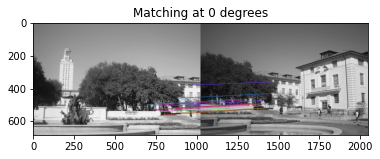

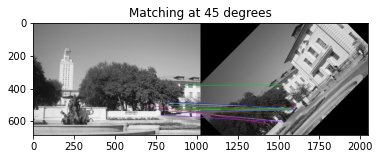

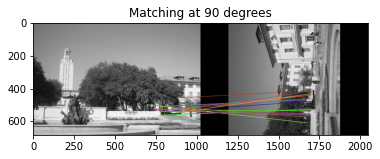

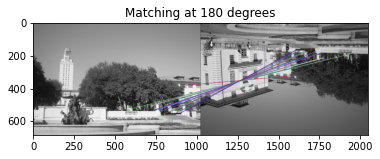

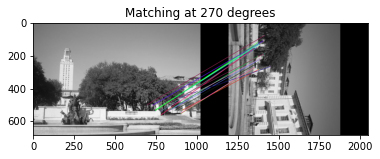

In [13]:
def rotate_and_match(image1_path, image2_path, angles):

    left_image = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create()

    keypoints_left, descriptors_left = orb.detectAndCompute(left_image, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for angle in angles:
        rows, cols = right_image.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated_right_image = cv2.warpAffine(right_image, M, (cols, rows))

        keypoints_right, descriptors_right = orb.detectAndCompute(rotated_right_image, None)

        matches = bf.match(descriptors_left, descriptors_right)
        matches = sorted(matches, key=lambda x: x.distance)

        N = 20
        best_matches = matches[:N]

        img_matches = cv2.drawMatches(left_image, keypoints_left, rotated_right_image, keypoints_right, best_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        for match in best_matches:
            pt_left = keypoints_left[match.queryIdx].pt
            pt_right = keypoints_right[match.trainIdx].pt

            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.line(img_matches, (int(pt_left[0]), int(pt_left[1])), (int(pt_right[0] + cols), int(pt_right[1])), color, 2)

        plt.imshow(img_matches)
        plt.title(f'Matching at {angle} degrees')
        plt.show()

# Example usage
rotate_and_match('./data/image_sample_1.jpeg', './data/image_sample_2.jpeg', [0, 45, 90, 180, 270])

### Module 2: Two View Image Alignment

#### Task 2.1: Using the feature detection code in the problem 1, build a set of putative feature correspondences using the following rules

#### a) Selected the top 20 features based on the similarity measure score

In [20]:
def compute_top_feature_correspondences(image1, image2, keypoints1, keypoints2, patch_size=15, similarity_measure='ssd', top_k=20):
    correspondences = []
    
    for keypoint1 in keypoints1:
        patch1 = image1[
            keypoint1[0] - patch_size // 2:keypoint1[0] + patch_size // 2 + 1,
            keypoint1[1] - patch_size // 2:keypoint1[1] + patch_size // 2 + 1
        ]

        # Calculate similarity scores
        scores = []

        for keypoint2 in keypoints2:
            patch2 = image2[
                keypoint2[0] - patch_size // 2:keypoint2[0] + patch_size // 2 + 1,
                keypoint2[1] - patch_size // 2:keypoint2[1] + patch_size // 2 + 1
            ]

            if similarity_measure == 'ssd':
                score = np.sum((patch1 - patch2) ** 2)
            elif similarity_measure == 'ncc':
                score = -np.sum((patch1 - np.mean(patch1)) * (patch2 - np.mean(patch2))) / (
                        np.std(patch1) * np.std(patch2) * patch_size * patch_size
                )
            else:
                raise ValueError("Invalid similarity_measure. Use 'ssd' or 'ncc'.")

            scores.append(score)

        # Find the top k matches
        top_matches = np.argsort(scores)[:top_k]

        # Add correspondences to the list
        for match_index in top_matches:
            keypoint2 = keypoints2[match_index]
            correspondences.append((keypoint1, keypoint2))

    return correspondences

In [21]:
# Example usage
image_left = cv2.imread("./data/image_sample_1.jpeg", cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread("./data/image_sample_2.jpeg", cv2.IMREAD_GRAYSCALE)

corners_left = harris_non_maxima_suppression(image_left)
corners_right = harris_non_maxima_suppression(image_right)

# Compute top 20 feature correspondences based on SSD
top_correspondences_ssd = compute_top_feature_correspondences(image_left, image_right, corners_left, corners_right, similarity_measure='ssd', top_k=20)

# Compute top 20 feature correspondences based on NCC
top_correspondences_ncc = compute_top_feature_correspondences(image_left, image_right, corners_left, corners_right, similarity_measure='ncc', top_k=20)

In [25]:
top_correspondences_ssd

[(array([494, 810], dtype=int64), array([462, 357], dtype=int64)),
 (array([494, 810], dtype=int64), array([463, 357], dtype=int64)),
 (array([494, 810], dtype=int64), array([450, 832], dtype=int64)),
 (array([494, 810], dtype=int64), array([333, 742], dtype=int64)),
 (array([494, 810], dtype=int64), array([381, 747], dtype=int64)),
 (array([494, 810], dtype=int64), array([330, 756], dtype=int64)),
 (array([494, 810], dtype=int64), array([458, 347], dtype=int64)),
 (array([494, 810], dtype=int64), array([462, 358], dtype=int64)),
 (array([494, 810], dtype=int64), array([517, 397], dtype=int64)),
 (array([494, 810], dtype=int64), array([463, 358], dtype=int64)),
 (array([494, 810], dtype=int64), array([455, 833], dtype=int64)),
 (array([494, 810], dtype=int64), array([462, 247], dtype=int64)),
 (array([494, 810], dtype=int64), array([387, 758], dtype=int64)),
 (array([494, 810], dtype=int64), array([474, 183], dtype=int64)),
 (array([494, 810], dtype=int64), array([374, 697], dtype=int6

In [26]:
top_correspondences_ncc

[(array([494, 810], dtype=int64), array([463, 357], dtype=int64)),
 (array([494, 810], dtype=int64), array([462, 357], dtype=int64)),
 (array([494, 810], dtype=int64), array([463, 358], dtype=int64)),
 (array([494, 810], dtype=int64), array([462, 358], dtype=int64)),
 (array([494, 810], dtype=int64), array([482, 178], dtype=int64)),
 (array([494, 810], dtype=int64), array([199, 744], dtype=int64)),
 (array([494, 810], dtype=int64), array([192, 766], dtype=int64)),
 (array([494, 810], dtype=int64), array([450, 831], dtype=int64)),
 (array([494, 810], dtype=int64), array([192, 765], dtype=int64)),
 (array([494, 810], dtype=int64), array([354, 282], dtype=int64)),
 (array([494, 810], dtype=int64), array([483, 178], dtype=int64)),
 (array([494, 810], dtype=int64), array([450, 832], dtype=int64)),
 (array([494, 810], dtype=int64), array([249, 822], dtype=int64)),
 (array([494, 810], dtype=int64), array([526, 490], dtype=int64)),
 (array([494, 810], dtype=int64), array([456, 381], dtype=int6

#### b) Select 30 random correspondences

In [27]:
def compute_random_feature_correspondences(image1, image2, keypoints1, keypoints2, patch_size=15, similarity_measure='ssd', num_random=30):
    correspondences = []

    for _ in range(num_random):
        keypoint1 = random.choice(keypoints1)
        patch1 = image1[
            keypoint1[0] - patch_size // 2:keypoint1[0] + patch_size // 2 + 1,
            keypoint1[1] - patch_size // 2:keypoint1[1] + patch_size // 2 + 1
        ]

        keypoint2 = random.choice(keypoints2)
        patch2 = image2[
            keypoint2[0] - patch_size // 2:keypoint2[0] + patch_size // 2 + 1,
            keypoint2[1] - patch_size // 2:keypoint2[1] + patch_size // 2 + 1
        ]

        if similarity_measure == 'ssd':
            score = np.sum((patch1 - patch2) ** 2)
        elif similarity_measure == 'ncc':
            score = -np.sum((patch1 - np.mean(patch1)) * (patch2 - np.mean(patch2))) / (
                    np.std(patch1) * np.std(patch2) * patch_size * patch_size
            )
        else:
            raise ValueError("Invalid similarity_measure. Use 'ssd' or 'ncc'.")

        correspondences.append((keypoint1, keypoint2))

    return correspondences


In [28]:
# Example usage
image_left = cv2.imread("./data/image_sample_1.jpeg", cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread("./data/image_sample_2.jpeg", cv2.IMREAD_GRAYSCALE)

corners_left = harris_non_maxima_suppression(image_left)
corners_right = harris_non_maxima_suppression(image_right)

# Compute 30 random feature correspondences based on SSD
random_correspondences_ssd = compute_random_feature_correspondences(image_left, image_right, corners_left, corners_right, similarity_measure='ssd', num_random=30)

# Compute 30 random feature correspondences based on NCC
random_correspondences_ncc = compute_random_feature_correspondences(image_left, image_right, corners_left, corners_right, similarity_measure='ncc', num_random=30)

In [29]:
random_correspondences_ncc

[(array([557, 581], dtype=int64), array([468, 838], dtype=int64)),
 (array([470, 274], dtype=int64), array([384, 694], dtype=int64)),
 (array([498, 699], dtype=int64), array([339, 748], dtype=int64)),
 (array([488, 781], dtype=int64), array([377, 683], dtype=int64)),
 (array([483, 695], dtype=int64), array([425, 984], dtype=int64)),
 (array([499, 292], dtype=int64), array([375, 835], dtype=int64)),
 (array([ 533, 1006], dtype=int64), array([516, 443], dtype=int64)),
 (array([423, 226], dtype=int64), array([329, 758], dtype=int64)),
 (array([497, 595], dtype=int64), array([383, 830], dtype=int64)),
 (array([546, 905], dtype=int64), array([383, 696], dtype=int64)),
 (array([535, 623], dtype=int64), array([463, 376], dtype=int64)),
 (array([525, 533], dtype=int64), array([477, 698], dtype=int64)),
 (array([529, 536], dtype=int64), array([457, 336], dtype=int64)),
 (array([474, 202], dtype=int64), array([521, 152], dtype=int64)),
 (array([388, 728], dtype=int64), array([375, 835], dtype=in

In [30]:
random_correspondences_ssd

[(array([476, 784], dtype=int64), array([506, 537], dtype=int64)),
 (array([170, 219], dtype=int64), array([387, 755], dtype=int64)),
 (array([484, 517], dtype=int64), array([393, 691], dtype=int64)),
 (array([423, 227], dtype=int64), array([383, 755], dtype=int64)),
 (array([493, 819], dtype=int64), array([515, 393], dtype=int64)),
 (array([492, 635], dtype=int64), array([469, 696], dtype=int64)),
 (array([516, 587], dtype=int64), array([330, 753], dtype=int64)),
 (array([471, 273], dtype=int64), array([456, 830], dtype=int64)),
 (array([459, 882], dtype=int64), array([375, 827], dtype=int64)),
 (array([560, 341], dtype=int64), array([439, 583], dtype=int64)),
 (array([497, 800], dtype=int64), array([340, 745], dtype=int64)),
 (array([487, 833], dtype=int64), array([397, 689], dtype=int64)),
 (array([475, 783], dtype=int64), array([496, 697], dtype=int64)),
 (array([492, 837], dtype=int64), array([478, 125], dtype=int64)),
 (array([445, 177], dtype=int64), array([509, 144], dtype=int6

#### Task 2.2: Implement a RANSAC-based method to estimate an affine transformation between uttower_left.jpg and uttower_right.jpg in the TwoViewAlignment directory. First, run using as input only the putative correspondences defined in a1. Second use the aggregate putative correspondences of BOTH a1 AND a2. Show the inlier matches determined by RANSAC procedure (with adaptive iteration number) and compute their average feature reprojection error between the images. Discuss what is the expected number of RANSAC iterations for each experiment and what is the actual number observed in practice. Include the results in your report.  

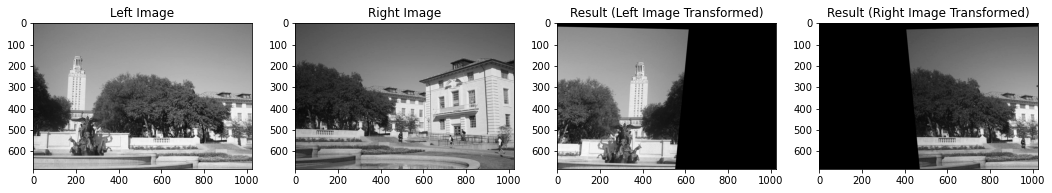

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ransac_affine_transform(matches, keypoints1, keypoints2, inlier_threshold=10, max_iterations=1000):
    best_affine_transform = None
    best_inliers = 0

    for _ in range(max_iterations):
        random_indices = np.random.choice(len(matches), 3, replace=False)
        random_matches = [matches[i] for i in random_indices]

        src_pts = np.float32([keypoints1[match.queryIdx].pt for match in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in random_matches]).reshape(-1, 1, 2)

        affine_transform = cv2.getAffineTransform(src_pts, dst_pts)

        transformed_points = cv2.transform(np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2), affine_transform)
        distances = np.linalg.norm(transformed_points - np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2), axis=2)
        inliers = np.sum(distances < inlier_threshold)
        
        if inliers > best_inliers:
            best_inliers = inliers
            best_affine_transform = affine_transform

    return best_affine_transform

image_left = cv2.imread("./data/image_sample_1.jpeg", cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread("./data/image_sample_2.jpeg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints_left, descriptors_left = orb.detectAndCompute(image_left, None)
keypoints_right, descriptors_right = orb.detectAndCompute(image_right, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_left, descriptors_right)

affine_transform = ransac_affine_transform(matches, keypoints_left, keypoints_right)

result_image_left = cv2.warpAffine(image_left, cv2.invertAffineTransform(affine_transform), (image_right.shape[1], image_right.shape[0]))
result_image_right = cv2.warpAffine(image_right, cv2.invertAffineTransform(affine_transform), (image_left.shape[1], image_left.shape[0]))

result_image_left = cv2.flip(result_image_left, 1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(image_left, cmap='gray')
plt.title('Left Image')

plt.subplot(1, 4, 2)
plt.imshow(image_right, cmap='gray')
plt.title('Right Image')

plt.subplot(1, 4, 3)
plt.imshow(result_image_left, cmap='gray')
plt.title('Result (Left Image Transformed)')

plt.subplot(1, 4, 4)
plt.imshow(result_image_right, cmap='gray')
plt.title('Result (Right Image Transformed)')

plt.show()

#### Task 2.3: Warp one image onto the other using the affine transformation estimates. To do this, you will need to learn about MATLAB maketform and imtransform functions (or their python/C counterparts). Create a new image big enough to hold the panorama and composite the two images into it. You may composite by simply averaging the pixel values where the two images overlap.

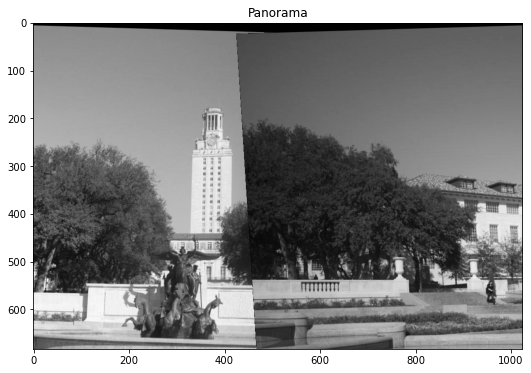

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ransac_affine_transform(matches, keypoints1, keypoints2, inlier_threshold=10, max_iterations=1000):
    best_affine_transform = None
    best_inliers = 0

    for _ in range(max_iterations):

        random_indices = np.random.choice(len(matches), 3, replace=False)
        random_matches = [matches[i] for i in random_indices]

        src_pts = np.float32([keypoints1[match.queryIdx].pt for match in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in random_matches]).reshape(-1, 1, 2)

        affine_transform = cv2.getAffineTransform(src_pts, dst_pts)

        transformed_points = cv2.transform(np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2), affine_transform)
        distances = np.linalg.norm(transformed_points - np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2), axis=2)
        inliers = np.sum(distances < inlier_threshold)

        if inliers > best_inliers:
            best_inliers = inliers
            best_affine_transform = affine_transform

    return best_affine_transform

def create_panorama(image1, image2):

    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    affine_transform = ransac_affine_transform(matches, keypoints1, keypoints2)
    
    result_image1 = cv2.warpAffine(image_left, cv2.invertAffineTransform(affine_transform), (image_right.shape[1], image_right.shape[0]))
    result_image2 = cv2.warpAffine(image_right, cv2.invertAffineTransform(affine_transform), (image_left.shape[1], image_left.shape[0]))

    result_image1 = cv2.flip(result_image1, 1)

    overlap_mask = np.logical_and(result_image1 > 0, result_image2 > 0)

    panorama = np.zeros_like(result_image1, dtype=np.float32)
    panorama[overlap_mask] = (result_image1[overlap_mask].astype(np.float32) + result_image2[overlap_mask].astype(np.float32)) / 2.0

    panorama[result_image1 > 0] = result_image1[result_image1 > 0]
    panorama[result_image2 > 0] = result_image2[result_image2 > 0]

    return panorama.astype(np.uint8)

image_left = cv2.imread("./data/image_sample_1.jpeg", cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread("./data/image_sample_2.jpeg", cv2.IMREAD_GRAYSCALE)

panorama = create_panorama(image_left, image_right)

plt.figure(figsize=(12, 6))
plt.imshow(panorama, cmap='gray')
plt.title('Panorama')
plt.show()

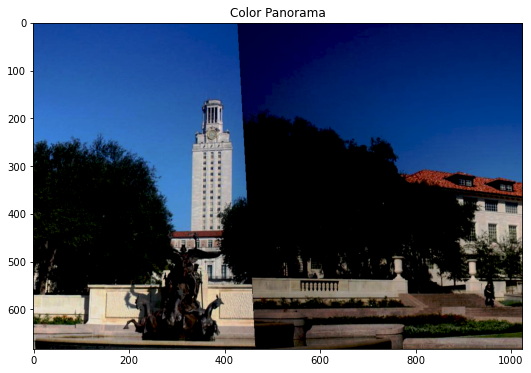

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, img_as_ubyte

def ransac_affine_transform(matches, keypoints1, keypoints2, inlier_threshold=10, max_iterations=1000):
    best_affine_transform = None
    best_inliers = 0

    for _ in range(max_iterations):
        # Randomly sample 3 point correspondences
        random_indices = np.random.choice(len(matches), 3, replace=False)
        random_matches = [matches[i] for i in random_indices]

        src_pts = np.float32([keypoints1[match.queryIdx].pt for match in random_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in random_matches]).reshape(-1, 1, 2)

        # Estimate affine transformation
        affine_transform = cv2.getAffineTransform(src_pts, dst_pts)

        # Transform all points and count inliers
        transformed_points = cv2.transform(np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2), affine_transform)
        distances = np.linalg.norm(transformed_points - np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2), axis=2)
        inliers = np.sum(distances < inlier_threshold)

        # Update best model if the current model has more inliers
        if inliers > best_inliers:
            best_inliers = inliers
            best_affine_transform = affine_transform

    return best_affine_transform

def create_color_panorama(image1, image2):
    # Detect keypoints and descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

    # Match keypoints between the two images
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Estimate affine transformation using RANSAC
    affine_transform = ransac_affine_transform(matches, keypoints1, keypoints2)
    
    result_image1 = cv2.warpAffine(image_left, cv2.invertAffineTransform(affine_transform), (image_right.shape[1], image_right.shape[0]))
    result_image2 = cv2.warpAffine(image_right, cv2.invertAffineTransform(affine_transform), (image_left.shape[1], image_left.shape[0]))

    result_image1 = cv2.flip(result_image1, 1)

    # Create a mask for the overlap region
    overlap_mask = np.logical_and(result_image1 > 0, result_image2 > 0)

    # Composite images by averaging pixel values in the overlap region
    panorama = np.zeros_like(result_image1, dtype=np.float32)
    panorama[overlap_mask] = (result_image1[overlap_mask].astype(np.float32) + result_image2[overlap_mask].astype(np.float32)) / 2.0

    # Fill in the non-overlapping regions
    panorama[result_image1 > 0] = result_image1[result_image1 > 0]
    panorama[result_image2 > 0] = result_image2[result_image2 > 0]

    # Perform color correction to compensate for color variation
    panorama = exposure.match_histograms(panorama.astype(np.uint8), result_image2.astype(np.uint8))

    return panorama.astype(np.uint8)

# Load color images
image_left = cv2.imread("./data/image_sample_1.jpeg")
image_right = cv2.imread("./data/image_sample_2.jpeg")

# Convert BGR to RGB
image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)
image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB)

# Create the color panorama
color_panorama = create_color_panorama(image_left, image_right)

# Display the color panorama
plt.figure(figsize=(12, 6))
plt.imshow(color_panorama)
plt.title('Color Panorama')
plt.show()